# <center>LANE IDENTIFICATION USING OPENCV</center>

### NOTEBOOK IMPORTS

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### IMPORTING LANE IMAGE

In [2]:
image = cv2.imread('test_image.jpg')

lane_image = image.copy()

def show_image(image, cmap=None):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap=cmap)
    plt.show()

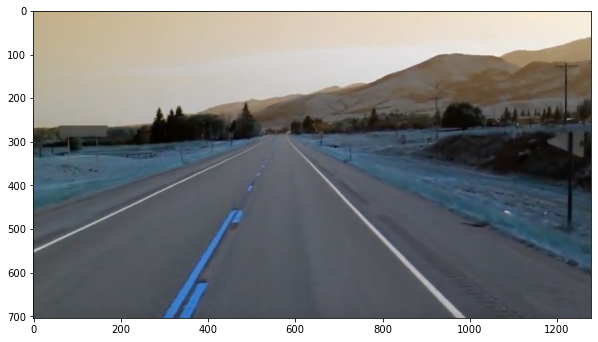

In [3]:
show_image(lane_image)

    in abouve figure it is in BGR format,opencv reads images/videos in BGR format.
    To convert it to RGB, which is matplotlib reading, we use BGR2RGB converter in opencv

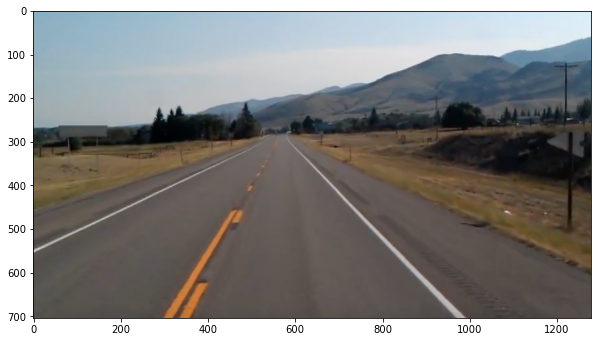

In [4]:
show_image(
    cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB)
)

### IMAGE PROCESSING

#### EDGE DETECTION (CANNY EDGE DETECTOR)
    We convert the lane image to
        1. Grayscale
        2. Apply GaussianBlur
        3. Apply Canny

In [5]:
def canny(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # blurring image with kernel size of 5
    blurred = cv2.GaussianBlur(src=image, ksize=(5, 5), sigmaX=0)
    
    # low threshold, high threshold
    canny = cv2.Canny(blurred, 50, 150)
    
    return canny

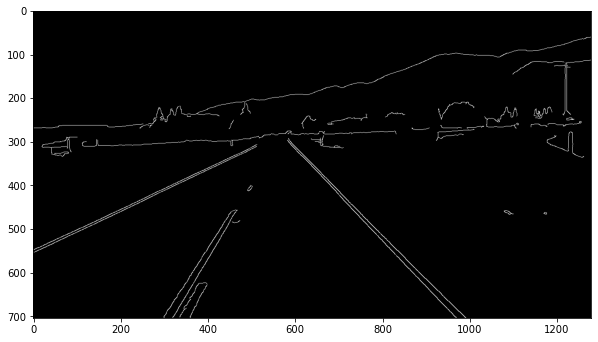

In [6]:
canny_image = canny(lane_image)
show_image(canny_image, cmap='gray')

#### BUILDING ROI (REGION OF INTEREST)

    From abouve image we need a triangle as region of interest, for identification of lane lines

    200px from X, 700px from y
    1100px from X, 700px from y
    550px from x, 250px from y
    to isolate the road lanes from whole image

In [7]:
def region_of_interest(image):
    
    # number of rows
    height = image.shape[0]
    
    # creating ROI
    triangle_polygon = np.array([
        [(200, height), (1100, height), (550, 250)]
    ])
    
    # creating black mask
    mask = np.zeros_like(image)
    
    # filling white color in mask on points of ROI
    # that means, creating a white triangel in mask
    cv2.fillPoly(mask, triangle_polygon, 255)
    
    # bitwise and inorder to get a ROI
    masked_image = cv2.bitwise_and(image, mask)
    
    return masked_image

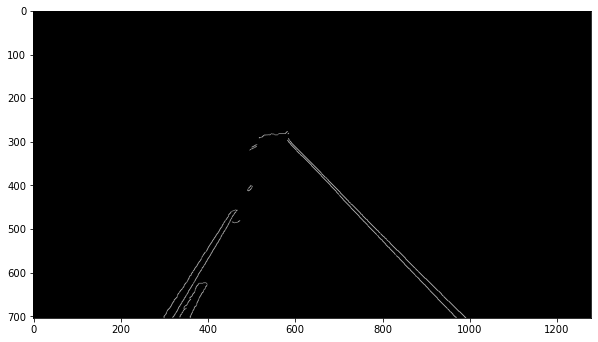

In [8]:
cropped_image = region_of_interest(canny_image)
show_image(cropped_image, cmap='gray')

#### HOUGH TRANSFORMATION

    Hough transformation is to detect lines in an image

In [9]:
# rho, theta, threshold, empty array, minlenght to consider as a line, maxgap to consider it is a line

lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
lines

array([[[703, 425, 766, 490]],

       [[750, 465, 834, 549]],

       [[383, 598, 431, 518]],

       [[299, 701, 386, 567]],

       [[891, 621, 947, 680]],

       [[704, 418, 927, 641]],

       [[588, 299, 660, 371]],

       [[585, 301, 628, 345]],

       [[645, 362, 687, 406]],

       [[767, 493, 890, 620]],

       [[322, 700, 378, 607]],

       [[396, 552, 453, 461]],

       [[356, 642, 455, 476]],

       [[592, 304, 663, 375]]], dtype=int32)

In [10]:
lines.shape

(14, 1, 4)

In [11]:
def display_lines(image, lines):
    
    lined_image = np.zeros_like(image)
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(lined_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    
    return lined_image

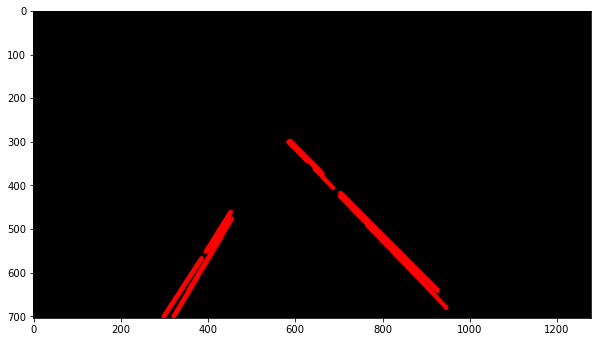

In [12]:
line_image = display_lines(lane_image, lines)
show_image(line_image)

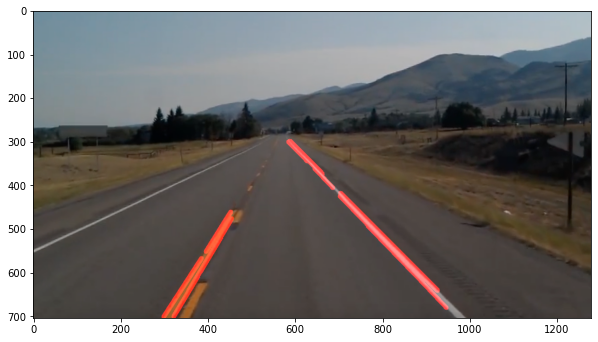

In [13]:
lane_identified = cv2.addWeighted(
    cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB), 0.8, 
    line_image, 1, 1
)
show_image(lane_identified)

#### AVERAGE OF LINES

    We still have a problem...we see multiple lines on same lanve.
    To solve this we only take the average of the two lines

    Below there are two functions for it,

    average_slope_intercept: This will find the average of lines by some high school math.
        It simply takes all lines and fit a first degree polynomial to it (y = mx + c) and
        returns a vector of coordinates that describe m and c

    using the slope(m), we need to create left and right fits. That is,
    As Y increases with X --> positive slope
       Y decreases with X --> negative slope

    make_corrdinate: Make the coordinate using slope and intercept

In [14]:
def make_coordinates(image, line_parameters):
    try:
        slope, intercept = line_parameters
    except:
        slope, intercept = 0.001, 0
        
    # we are providing y value manually
    # this is because we need our line to have a certain distance below
    # to ensure that road is covered completely
    y1 = image.shape[0]
    y2 = int(y1 * (3/5))
    
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    
    return np.array([x1, y1, x2, y2])

In [15]:
def average_slope_intercept(image, lines):
    
    left_fit = []
    right_fit = []
    
    if lines is None:
        return None
    
    for line in lines:
        
        x1, y1, x2, y2 = line.reshape(4)
        
        # fitting polynomial
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        
        slope = parameters[0]
        intercept = parameters[1]
        
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
            
    # taking average        
    left_fit_avg = np.average(left_fit, axis=0)
    right_fit_avg = np.average(right_fit, axis=0)
    
    left_line = make_coordinates(image, left_fit_avg)
    right_line = make_coordinates(image, right_fit_avg)
    
    
    return np.array([left_line, right_line])

In [16]:
average_lines = average_slope_intercept(lane_image, lines)
average_lines

array([[311, 704, 484, 422],
       [980, 704, 704, 422]])

In [17]:
lines

array([[[703, 425, 766, 490]],

       [[750, 465, 834, 549]],

       [[383, 598, 431, 518]],

       [[299, 701, 386, 567]],

       [[891, 621, 947, 680]],

       [[704, 418, 927, 641]],

       [[588, 299, 660, 371]],

       [[585, 301, 628, 345]],

       [[645, 362, 687, 406]],

       [[767, 493, 890, 620]],

       [[322, 700, 378, 607]],

       [[396, 552, 453, 461]],

       [[356, 642, 455, 476]],

       [[592, 304, 663, 375]]], dtype=int32)

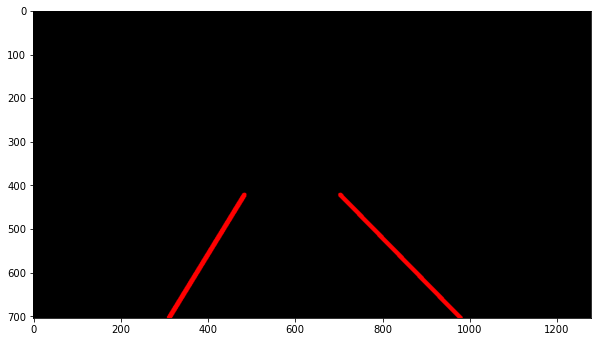

In [18]:
avg_line_image = display_lines(lane_image, average_lines)
show_image(avg_line_image)

### LANE DETECTED IMAGE

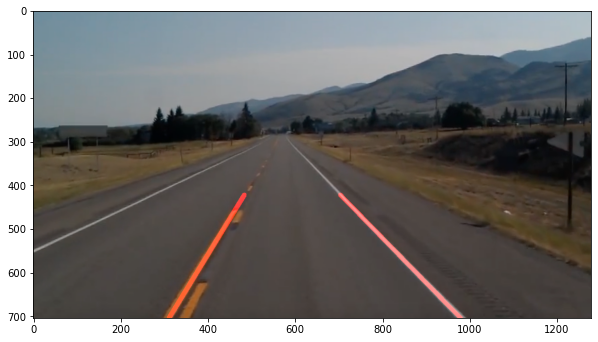

True

In [19]:
lane_identified_image = cv2.addWeighted(
    cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB), 0.8,
    avg_line_image, 1, 1
)

show_image(lane_identified_image)

cv2.imwrite('lane-dentified.png',cv2.cvtColor(lane_identified_image, cv2.COLOR_BGR2RGB))

### LANE DETECTION IN VIDEO

    1. Read the frame one by one
    2. Apply Canny edge detector
    3. ROI finding
    4. Getting lines of lanes from image
    5. Average the lines
    6. Display average lines on image
    7. Display the window

In [31]:
cap = cv2.VideoCapture('road.mp4')

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while True:
    
    _, frame = cap.read()
    
    canny_image = canny(frame)
    
    cropped_image = region_of_interest(canny_image)
    
    lines = cv2.HoughLinesP(
        cropped_image, 2, 
        np.pi/180, 100, np.array([]),
        minLineLength=40, maxLineGap=5
    )
    
    average_lines = average_slope_intercept(frame, lines)
    
    avg_line_image = display_lines(frame, average_lines)
    
    lane_identified_image = cv2.addWeighted(
        cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 0.8,
        avg_line_image, 1, 1
    )
    
    cv2.imshow('The-Window', cv2.cvtColor(lane_identified_image, cv2.COLOR_BGR2RGB))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

<img src="lane-identified.gif">